In [1]:
import numpy as np
import pandas as pd
import os
import random
import glob
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
path = '/Beijing' # use your path
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []

for file_ in allFiles:
    tempDF = pd.read_csv(file_,index_col=None, header=0)
    list_.append(tempDF)
df = pd.concat(list_)

print(df)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
#df = df.sort_values(['year', 'month', 'day', 'hour'])
cols = ['date', 'NO2', 'O3', 'TEMP', 'station']
df = df.sort_values(['station', 'date'])
df = df[cols]
print(df)

          No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0          1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1          2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2          3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3          4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4          5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
35059  35060  2017      2   28    19   11.0  32.0   3.0  24.0  400.0  72.0   
35060  35061  2017      2   28    20   13.0  32.0   3.0  41.0  500.0  50.0   
35061  35062  2017      2   28    21   14.0  28.0   4.0  38.0  500.0  54.0   
35062  35063  2017      2   28    22   12.0  23.0   4.0  30.0  400.0  59.0   
35063  35064  2017      2   28    23   13.0  19.0   4.0  38.0  600.0  49.0   

       TEMP    PRES  DEWP  RAIN   wd  WSPM        station  
0  

In [3]:
df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['date'], axis=1)
data.index = df.date
print(df)
df = df.groupby(['date']).agg({'NO2': 'mean', 'O3': 'mean','TEMP': 'mean'})
print(df)

                     date   NO2    O3  TEMP        station
0     2013-03-01 00:00:00   7.0  77.0  -0.7   Aotizhongxin
1     2013-03-01 01:00:00   7.0  77.0  -1.1   Aotizhongxin
2     2013-03-01 02:00:00  10.0  73.0  -1.1   Aotizhongxin
3     2013-03-01 03:00:00  11.0  72.0  -1.4   Aotizhongxin
4     2013-03-01 04:00:00  12.0  72.0  -2.0   Aotizhongxin
...                   ...   ...   ...   ...            ...
35059 2017-02-28 19:00:00  24.0  72.0  12.5  Wanshouxigong
35060 2017-02-28 20:00:00  41.0  50.0  11.6  Wanshouxigong
35061 2017-02-28 21:00:00  38.0  54.0  10.8  Wanshouxigong
35062 2017-02-28 22:00:00  30.0  59.0  10.5  Wanshouxigong
35063 2017-02-28 23:00:00  38.0  49.0   8.6  Wanshouxigong

[420768 rows x 5 columns]
                           NO2         O3       TEMP
date                                                
2013-03-01 00:00:00  12.600000  75.416667  -0.916667
2013-03-01 01:00:00  13.111111  75.750000  -1.216667
2013-03-01 02:00:00  12.900000  66.000000  -1.591667


In [4]:
print(df)

                           NO2         O3       TEMP
date                                                
2013-03-01 00:00:00  12.600000  75.416667  -0.916667
2013-03-01 01:00:00  13.111111  75.750000  -1.216667
2013-03-01 02:00:00  12.900000  66.000000  -1.591667
2013-03-01 03:00:00  12.400000  75.333333  -1.891667
2013-03-01 04:00:00  14.000000  66.333333  -2.283333
...                        ...        ...        ...
2017-02-28 19:00:00  28.818182  71.900000  12.000000
2017-02-28 20:00:00  41.666667  56.545455  10.933333
2017-02-28 21:00:00  40.833333  54.000000  10.041667
2017-02-28 22:00:00  40.166667  53.250000   9.225000
2017-02-28 23:00:00  50.416667  41.000000   7.741667

[35064 rows x 3 columns]


In [5]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

NO2 : 0.002481177275838467
O3 : 0.003051562856490988
TEMP : 0.000513347022587269


In [6]:
def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [7]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['year'] = df_external.date.dt.year
df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
#df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['year','month','day'])
df_external.drop(['year','month','day'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(35064, 6)


,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos
date,,,,,,
2013-03-01 00:00:00,-0.01246,0.999922,1.0,6.123234e-17,-0.866025,-0.5
2013-03-01 01:00:00,-0.01246,0.999922,1.0,6.123234e-17,-0.866025,-0.5
2013-03-01 02:00:00,-0.01246,0.999922,1.0,6.123234e-17,-0.866025,-0.5
2013-03-01 03:00:00,-0.01246,0.999922,1.0,6.123234e-17,-0.866025,-0.5
2013-03-01 04:00:00,-0.01246,0.999922,1.0,6.123234e-17,-0.866025,-0.5


In [8]:
train_date = df.index[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_date = df.index[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)

(28051, 3) (7013, 3)


In [9]:

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

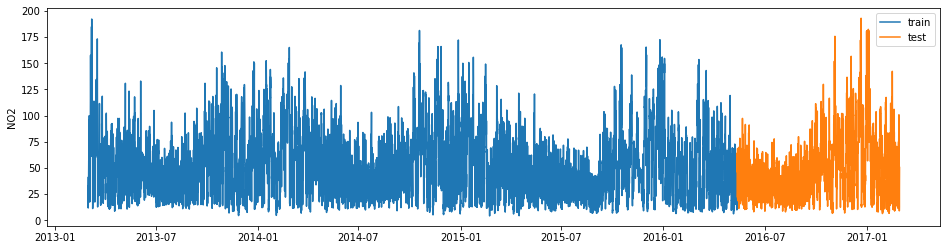

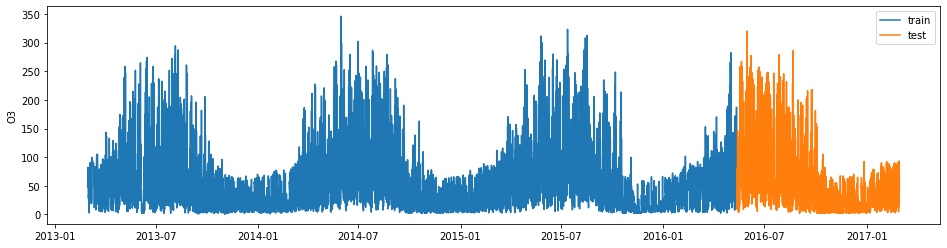

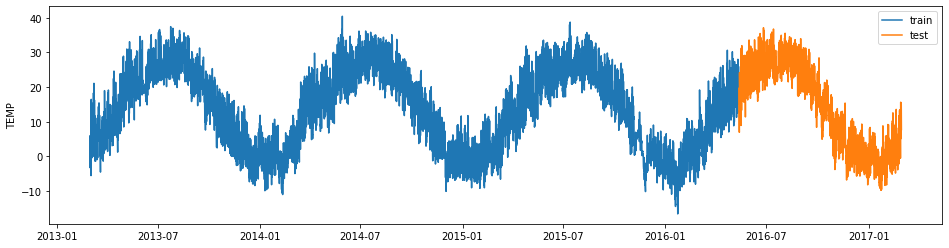

In [10]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

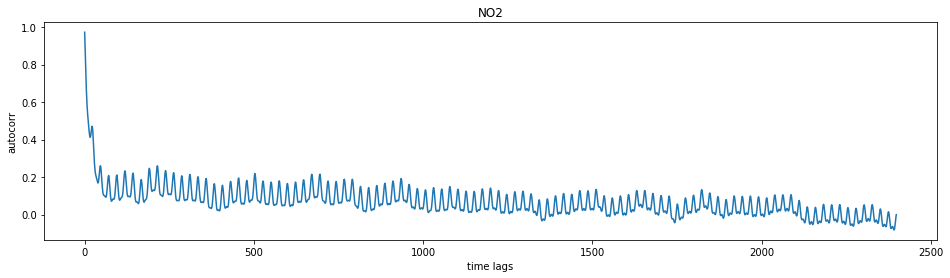

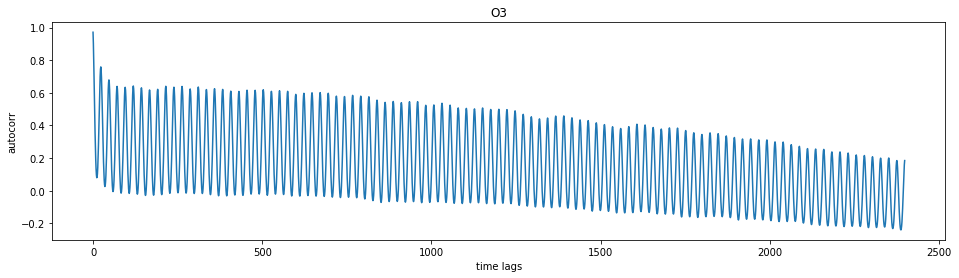

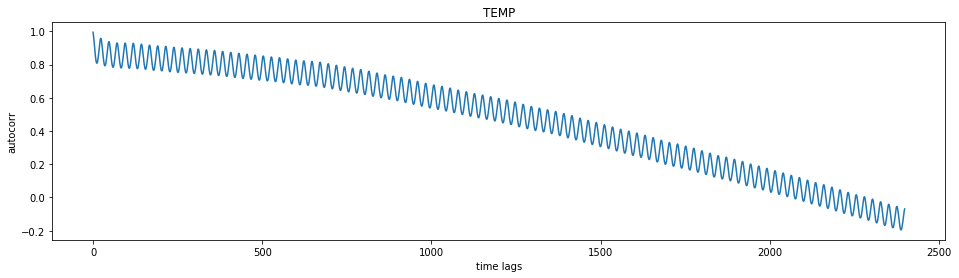

In [11]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [12]:
### OPERATE DIFFERENTIATION ###

period = 24*7

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()

In [13]:

### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(27883, 3) (27883, 3) (27883, 6)
(7013, 3) (7013, 3) (7013, 6)


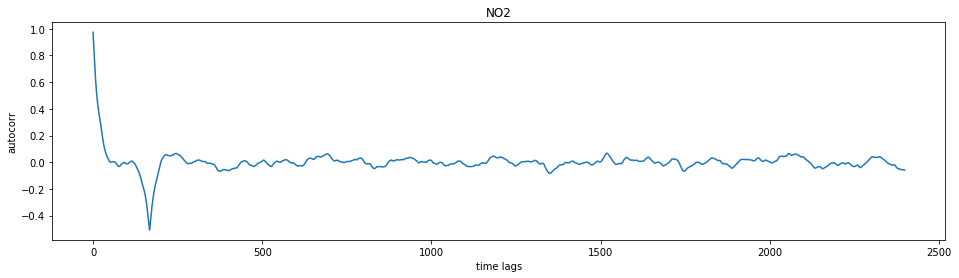

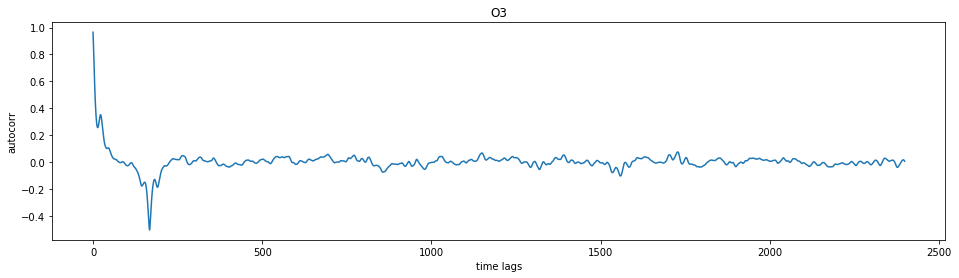

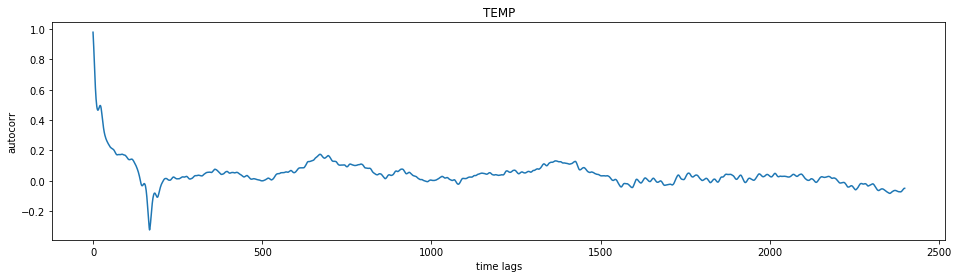

In [14]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [15]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,200):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 187 BEST AIC: 7.041151867678465


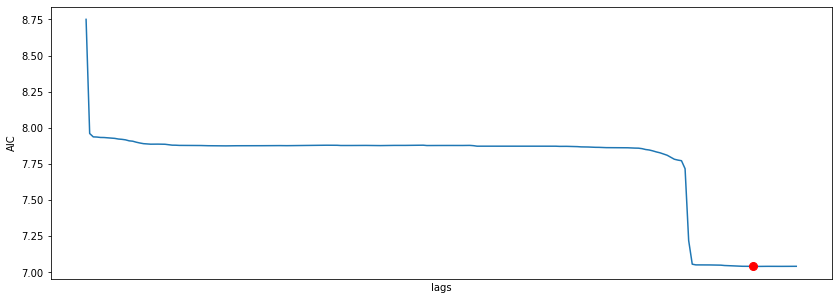

In [16]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,200))
plt.xlabel('lags'); plt.ylabel('AIC')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
np.set_printoptions(False)

In [17]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

7.041151867678465

In [18]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [19]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2015-01-01 00:00:00'
forward = 100
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

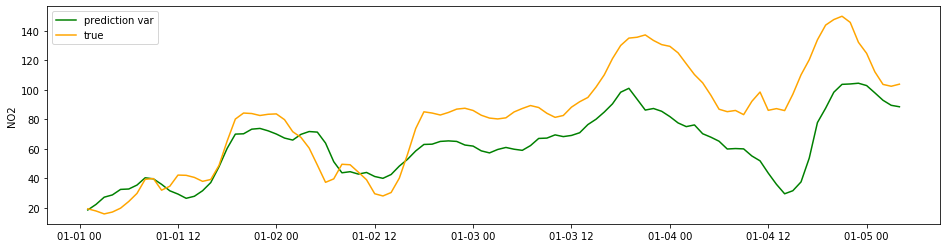

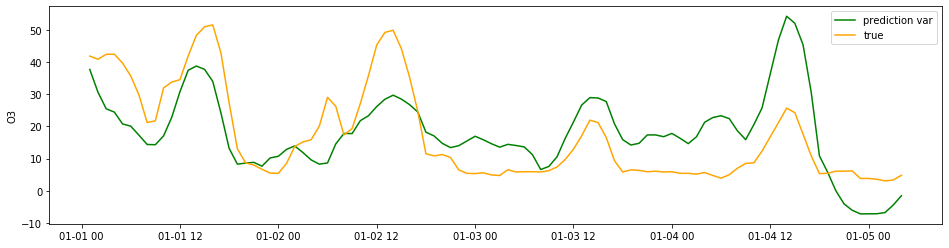

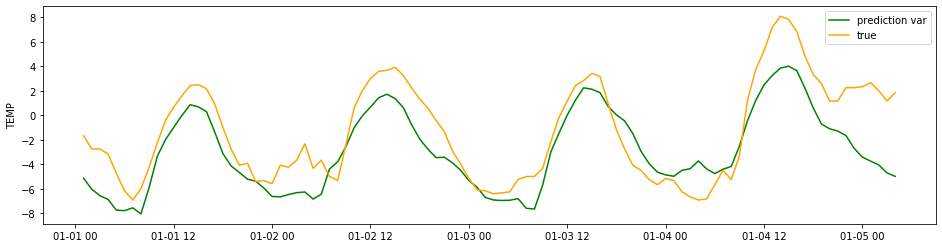

In [20]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [21]:

### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 30

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 9))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(3)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [22]:

### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X, train_ext.iloc[best_order:].values], axis=1)

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

In [23]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [24]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

In [25]:
### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###
#tf.compat.v1.disable_eager_execution()
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 692 steps, validate for 173 steps
Epoch 1/100
692/692 [==============================] - 20s 29ms/step - loss: 0.6113 - val_loss: 0.4336
Epoch 2/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4921 - val_loss: 0.3931
Epoch 3/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4604 - val_loss: 0.3608
Epoch 4/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4473 - val_loss: 0.3484
Epoch 5/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4320 - val_loss: 0.3556
Epoch 6/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4157 - val_loss: 0.3496
Epoch 7/100
692/692 [==============================] - 16s 24ms/step - loss: 0.4090 - val_loss: 0.3205
Epoch 8/100
692/692 [==============================] - 1

In [26]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

Instructions for updating:
Please use Model.predict, which supports generators.


In [27]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 692 steps, validate for 173 steps
Epoch 1/100
692/692 [==============================] - 18s 26ms/step - loss: 0.6055 - val_loss: 0.4217
Epoch 2/100
692/692 [==============================] - 15s 22ms/step - loss: 0.4849 - val_loss: 0.3808
Epoch 3/100
692/692 [==============================] - 15s 22ms/step - loss: 0.4524 - val_loss: 0.3534
Epoch 4/100
692/692 [==============================] - 15s 22ms/step - loss: 0.4399 - val_loss: 0.3433
Epoch 5/100
692/692 [==============================] - 15s 22ms/step - loss: 0.4239 - val_loss: 0.3481
Epoch 6/100
692/692 [==============================] - 15s 22ms/step - loss: 0.4088 - val_loss: 0.3424
Epoch 7/100
692/692 [==============================] - 16s 22ms/step - loss: 0.4020 - val_loss: 0.3141
Epoch 8/100
692/692 [==============================] - 16s 23ms/step - loss: 0.3856 - val_loss: 0.2970
Epoch 9/100
692/692 [==============================] - 16s 22ms/step - loss: 0.375

In [28]:
### OBTAIN PREDICTIONS ###

pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)

In [29]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

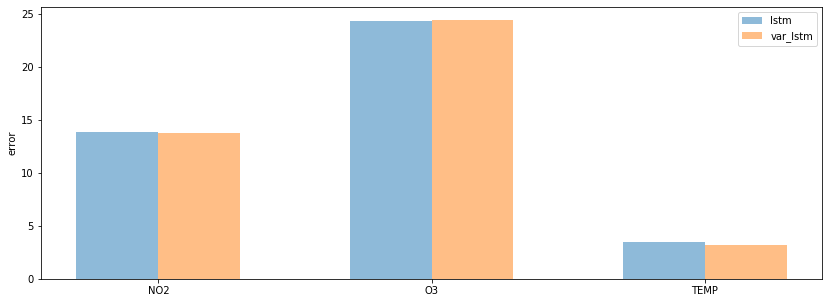

In [30]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

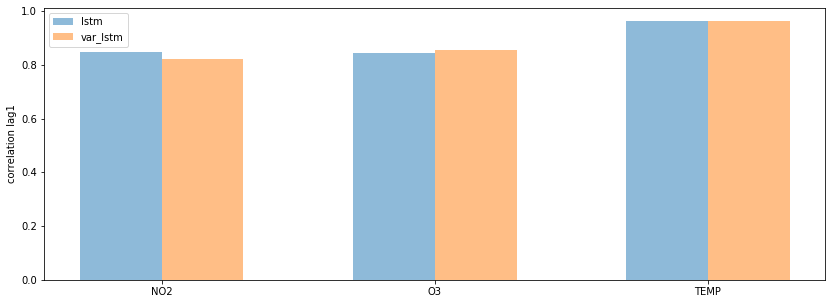

In [31]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)